In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as misc
%matplotlib inline

## EM with Single Confusion Matrix

In [2]:
def E_step(rho, theta, r):
    num_data = r.shape[0]
    num_classes = theta.shape[0]
    num_experts = r.shape[1]
    
    zeds = np.zeros((num_data, num_classes))
    
    for i in range(num_data):
        for k in range(num_classes):
            log_numerator = np.log(rho[k]) + np.sum([[np.sum(r[i,j]==t)*np.log(theta[k,t]) \
                                                      for j in range(num_experts)] for t in range(num_classes)])
            log_denominator = misc.logsumexp([np.log(rho[k_p]) + np.sum([[np.sum(r[i,j]==t)*np.log(theta[k_p,t]) \
                                                for j in range(num_experts)] for t in range(num_classes)]) \
                                              for k_p in range(num_classes)])
            zeds[i,k] = np.exp(log_numerator - log_denominator)
    return zeds

In [3]:
def M_step(z,r):
    num_classes = z.shape[1]
    num_data = z.shape[0]
    num_experts = r.shape[1]
    
    thet = np.zeros((num_classes,num_classes))
    for k in range(num_classes):
        for t in range(num_classes):
            numerator=0
            denominator=0
            for i in range(num_data):
                for j in range(num_classes):
                    numerator += np.sum(z[i,k][r[i,j]==t])
                    denominator += np.sum([np.sum(z[i,k][r[i,j]==t_p]) for t_p in range(num_classes)])
  
            thet[k,t] = numerator/denominator
    
    rh = np.zeros(num_classes)
    for k in range(num_classes):
        rh[k] = np.sum(z[:,k])/np.sum(z)
            
    return thet, rh

In [4]:
# A function to run it:

def results_shared_conf(data_file, true_class_file):
    data = np.load(data_file)
    trueCls = np.load(true_class_file)
    
    # Reconfigure data to resemble that used in Liu and Wang
    r = np.argmax(data,axis=2)

    # Number of data points
    num_data     = data.shape[0]
    # Number of experts performing classification
    num_experts  = data.shape[1]
    # Number of classes
    num_classes  = data.shape[2]

    # Initialize rho, the proportion of each class, to be even.  
    rho = np.repeat(1./num_classes, num_classes)

    # Initialize the shared confusion matrix with a bias lambda
    lambdaa = 5.
    theta = np.ones((num_classes,num_classes))*(1./(lambdaa+num_classes))
    np.fill_diagonal(theta, np.repeat((lambdaa/(lambdaa+num_classes)),num_classes))

    # Nonsense initial values to test convergence
    z_old = 500
    z = 100
    ctr = 0

    while np.sum(z_old - z) > .00001:
        z_old = z
        z = E_step(rho, theta, r)
        theta, rho = M_step(z, r)
        ctr+=1

    accuracy = 100.*np.sum(np.argmax(z,axis=1)==trueCls)/num_data
    
    print "---------------------------------------------------------------"
    print "Shared Confusion Matrix"
    print "{} data points".format(num_data)
    print "Converged within {} iterations".format(ctr)
    print "Theta:"
    print theta
    print "Rho:", rho
    print "Accuracy is {}%".format(accuracy)
    print
    
    return accuracy
    

## EM, multiple confusion matrices

In [5]:
def E_step2(rho, r, thetas):
    num_data = r.shape[0]
    num_classes = thetas.shape[1]
    num_experts = r.shape[1]    
    
    zeds = np.zeros((num_data, num_classes))
    
    for i in range(num_data):
        for k in range(num_classes):
            log_numerator = np.log(rho[k]) + np.sum([thetas[j,k,r[i,j]] for j in range(num_experts)])
            log_denominator = misc.logsumexp([np.log(rho[k_p]) + np.sum([thetas[j,k_p,r[i,j]]\
                                                                       for j in range(num_experts)]) \
                                                                          for k_p in range(num_classes)])
            zeds[i,k] = np.exp(log_numerator - log_denominator)
            
    return zeds

In [6]:
def M_step2(z, r):
    num_classes = z.shape[1]
    num_data = z.shape[0]
    num_experts = r.shape[1]
    
    thet = np.zeros((num_experts,num_classes,num_classes))
    for k in range(num_classes):
        for t in range(num_classes):
            for j in range(num_experts):
                numerator=0
                denominator=0
                for i in range(num_data):
                    numerator += np.sum(z[i,k][r[i,j]==t])
                    denominator += np.sum([np.sum(z[i,k][r[i,j]==t_p]) for t_p in range(num_classes)])
                thet[j,k,t] = numerator/denominator
    
    rh = np.zeros(num_classes)
    for k in range(num_classes):
        rh[k] = np.sum(z[:,k])/np.sum(z)
            
    return thet, rh
                    

In [7]:
# Now run it:

def results_separate_conf(data_file, true_class_file):
    data = np.load(data_file)
    trueCls = np.load(true_class_file)    
    # Reconfigure data to resemble that used in Liu and Wang
    r = np.argmax(data,axis=2)

    # Number of data points
    num_data     = data.shape[0]
    # Number of experts performing classification
    num_experts  = data.shape[1]
    # Number of classes
    num_classes  = data.shape[2]

    # Initialize rho, the proportion of each class, to be even.  
    rho = np.repeat(1./num_classes, num_classes)

    # Initialize the shared confusion matrix with a bias lambda
    lambdaa = 5.
    theta = np.ones((num_classes,num_classes))*(1./(lambdaa+num_classes))
    np.fill_diagonal(theta, np.repeat((lambdaa/(lambdaa+num_classes)),num_classes))
    
    # All the confusion matrices start out the same
    thetas = np.stack([theta]*num_experts)

    # Nonsense initial values to test convergence
    z_old = 500
    z = 100
    ctr = 0

    while np.sum(z_old - z) > .00001:
        z_old = z
        z = E_step2(rho, r, thetas)
        thetas, rho = M_step2(z, r)
        ctr+=1

    accuracy = 100.*np.sum(np.argmax(z,axis=1)==trueCls)/num_data
    
    print "---------------------------------------------------------------"
    print "Separate Confusion Matrices"
    print "{} data points".format(num_data)
    print "Converged within {} iterations".format(ctr)
    print "Theta:"
    print thetas
    print "Rho:", rho
    print "Accuracy is {}%".format(accuracy)
    print
    
    return accuracy

In [8]:
ran = ['40','80','100','200','500']
results_shared=np.zeros(len(ran))
results_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/preset_MC_'+num+'_5_4.npz.npy'
    trueCls = '../data/preset_MC_'+num+'_5_4_reference_classes.npy'
    results_shared[ii] = results_shared_conf(data, trueCls)
    results_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[  9.04362233e-01   4.50557416e-02   2.53416402e-02   2.52403850e-02]
 [  5.48653195e-02   9.20397974e-01   3.82469151e-07   2.47363239e-02]
 [  2.49760152e-02   5.02084703e-02   9.24815490e-01   2.43117252e-08]
 [  7.51179541e-02   1.05904612e-07   7.49967395e-02   8.49885200e-01]]
Rho: [ 0.24725674  0.25266898  0.25002987  0.2500444 ]
Accuracy is 100.0%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.70459973  0.07103949  0.06459989  0.15976089]
  [ 0.07277739  0.77489563  0.07818466  0.07414232]
  [ 0.05573941  0.06949027  0.78251458  0.09225574]
  [ 0.05895364  0.06503396  0.06544907  0.81056333]]

 [[ 0.70334707  0.10086089  0.13575022  0.06004183]
  [ 0.21528457  0.65911004  0.0811141   0.04449129]
  [ 0.11866448  0.06312256  0.76644269  0.

In [9]:
ran = ['40','80','100','200','500']
results_hard_shared=np.zeros(len(ran))
results_hard_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/hard_preset_MC_'+num+'_5_4.npz.npy'
    trueCls = '../data/hard_preset_MC_'+num+'_5_4_reference_classes.npy'
    results_hard_shared[ii] = results_shared_conf(data, trueCls)
    results_hard_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[ 0.72172829  0.10013574  0.11728798  0.06084799]
 [ 0.00107322  0.86074608  0.05599006  0.08219064]
 [ 0.02535021  0.10081816  0.8232841   0.05054753]
 [ 0.15458393  0.12174368  0.04909853  0.67457386]]
Rho: [ 0.26340998  0.22217686  0.25046779  0.26394537]
Accuracy is 97.5%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.5068209   0.19032236  0.11755529  0.18530144]
  [ 0.12763035  0.49448081  0.13360073  0.24428811]
  [ 0.09947751  0.27699185  0.43793533  0.18559531]
  [ 0.17442299  0.23762549  0.07739732  0.5105542 ]]

 [[ 0.54507259  0.15380224  0.15886773  0.14225745]
  [ 0.12332638  0.59380394  0.11852109  0.16434858]
  [ 0.12508187  0.10708838  0.62565446  0.14217528]
  [ 0.2157459   0.15582759  0.15117975  0.47724677]]

 [[ 0.38436457  0

In [10]:
ran = ['40','80','100','200','500']
results_extrahard_shared=np.zeros(len(ran))
results_extrahard_separate=np.zeros(len(ran))

for ii, num in enumerate(ran):
    data = '../data/extrahard_MC_'+num+'_5_4.npz.npy'
    trueCls = '../data/extrahard_MC_'+num+'_5_4_reference_classes.npy'
    results_extrahard_shared[ii] = results_shared_conf(data, trueCls)
    results_extrahard_separate[ii] = results_separate_conf(data, trueCls)


---------------------------------------------------------------
Shared Confusion Matrix
40 data points
Converged within 2 iterations
Theta:
[[ 0.67841758  0.06463535  0.07754329  0.17940378]
 [ 0.16663975  0.6130368   0.15656751  0.06375594]
 [ 0.0314023   0.07782152  0.68963642  0.20113975]
 [ 0.10250931  0.11875205  0.19862498  0.58011366]]
Rho: [ 0.24985445  0.25153834  0.26416265  0.23444456]
Accuracy is 90.0%

---------------------------------------------------------------
Separate Confusion Matrices
40 data points
Converged within 2 iterations
Theta:
[[[ 0.38169501  0.22055959  0.18139226  0.21635315]
  [ 0.1464923   0.48327289  0.19761414  0.17262068]
  [ 0.11435532  0.18918553  0.46242333  0.23403583]
  [ 0.15957372  0.2341612   0.23077649  0.37548859]]

 [[ 0.41238617  0.15513643  0.28770163  0.14477577]
  [ 0.23576236  0.35547535  0.24155758  0.16720471]
  [ 0.20177271  0.14985028  0.47355202  0.17482499]
  [ 0.25293998  0.15803331  0.37523197  0.21379474]]

 [[ 0.28457894  0

(0, 105)

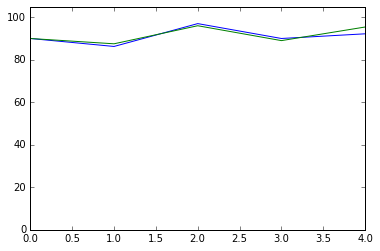

In [12]:
plt.plot(results_extrahard_shared)
plt.plot(results_extrahard_separate)
plt.ylim(0,105)
